# Linear Filtering in MsPASS
## Overview
Standard linear, filtering is a first-order step in most seismology processing workflows.   In fact, there are many situations where multiple filters are applied for different processing steps with different objectives.  The topic of this section is linear filters, which means filters that are implemented as linear operators. These can be FIR filters implemented by convolution, IIR filters implemented by recursion using a finite set of coefficients, or filters performed purely in the frequency domain.   The focus of this tutorial is limited, however, to simple filters for the basic operation of bandpass filtering. 

At the time of the drafting of this tutorial there were two distinctly different ways to do bandpass filtering:
1.  A method using wrappers we developed in mspass to utilize obspy filter functions. 
2. A butterworth filter method written in C++ based on Seismic Unix code that operates directly on native MsPASS data objects.  
This notebook is set up as test for validation of the C++ code against the obspy code.  It also computes some benchmarks with random noise to show the relative performance of the two methods.

## Generate working signals 
The first thing we need in this tutorial is some basic signals we can use to demonstrate the behavior of these filters.  


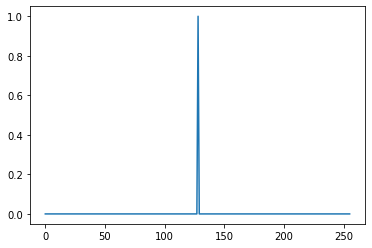

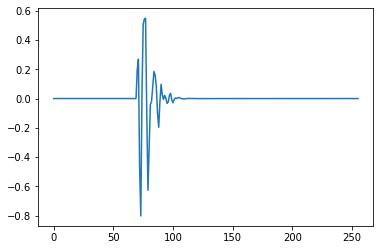

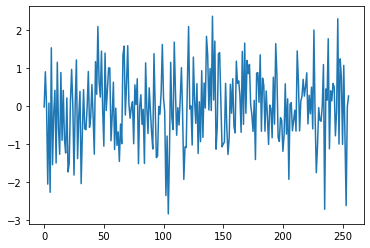

In [2]:
from mspasspy.ccore.seismic import (TimeSeries,
                                    Seismogram,
                                    CoreSeismogram,
                                    CoreTimeSeries)
from mspasspy.ccore.algorithms.basic import Butterworth
import mspasspy.algorithms.signals as mspass_signals
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
# We use this little function to make a signal that looks a bit like a single isolated seismic phase
def make_impulse_vector(lag,imp,n=500):
    """
    Computes a (sparse) vector of impulse functions at a specified set of
    lags.   Used for generating fake data for a number of contexts.

    :param lag: is a list of lag values (int in samples) parallel with imp
    :param imp: is a list of values (amplitudes) for each lag.  Algorithm is
       simply to insert imp value at specified lag.
    :param n: length of output vector returned.
    :return: numpy vector of doubles of length n.  zero where lag,imp not defined.
    """
    if(len(lag)!=len(imp)):
        raise RuntimeError("make_impulse_vector:  lag and imp vectors must be equal length")
    d=np.ndarray(n)
    for i in range(n):
        d[i]=0.0
    for i in range(len(lag)):
        if((lag[i]<0) | (lag[i]>=n)):
            raise RuntimeError("make_impulse_vector:  lag out of range");
        d[lag[i]]=imp[i]
    return d

# For initial testing I'll use a CoreTimeSeries here but api changes should allow this to be 
# changed to a TimeSeries.  
x=CoreTimeSeries()
d1=TimeSeries(x,'undefined')
npts=256
d1.npts=256
d1.set_live()
d1.dt=0.05
d1.data[128]=1.0
# Make two deep copies as additional base containers
d2=TimeSeries(d1)
d3=TimeSeries(d1)
t=np.linspace(x.t0,x.time(255),256)
# We use d1 as a spike for a pure impulse response
d1.t0 = (-128*x.dt)
# d2 is a fake signal that is a minimum phase wavelet
imp=(2.0,-1.5,0.4,-0.1)
lag=(70,74,85,95)
x=make_impulse_vector(lag,imp,npts)
sos=signal.butter(3,[2.0,6.0],btype='bandpass',output='sos',fs=20)
f=signal.sosfilt(sos,x)
for i in range(npts):
    d2.data[i]=f[i]
# we make d3 gaussian white noise
x=np.random.randn(npts)
for i in range(npts):
    d3.data[i]=x[i]
plt.plot(t,d1.data)
plt.show()
plt.plot(t,d2.data)
plt.show()
plt.plot(t,d3.data)
plt.show()




## Basic Filtering
### Obspy
First, we use the mspass wrapped obspy bandpass filter routine to filter all three of these signals in the band of 0.5 to 2 Hz.  We use their stock Butterworth filter with 2 poles on the high and low corners.  

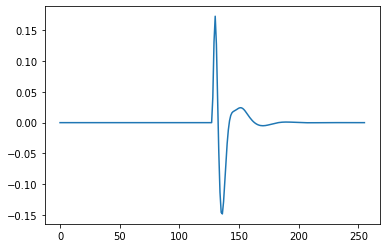

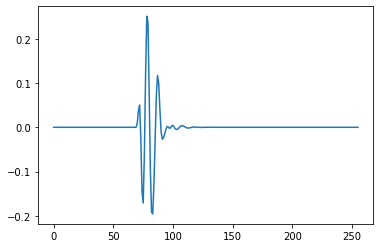

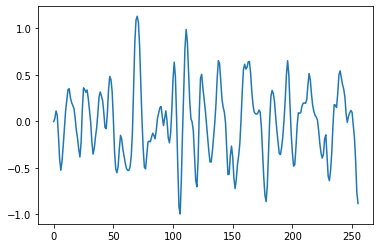

In [3]:
d=TimeSeries(d1)
mspass_signals.filter(d,"bandpass", freqmin=0.5, freqmax=2.0,corners=2)
plt.plot(t,d.data)
plt.show()
d=TimeSeries(d2)
mspass_signals.filter(d,"bandpass", freqmin=0.5, freqmax=2.0,corners=2)
plt.plot(t,d.data)
plt.show()
d=TimeSeries(d3)
mspass_signals.filter(d,"bandpass", freqmin=0.5, freqmax=2.0,corners=2)
plt.plot(t,d.data)
plt.show()

Notice that the call to the mspass filter routine uses identical arguments as the parallel obspy filter routine.  The only distinction is the function is accepting the mspass data object (TimeSeries) instead of the obspy native Trace object.   

### MsPASS Butterworth Filter
At the time of writing of this tutorial the only linear filter in MsPASS is a butterworth filter directly comparable too the one we just ran supplied by obspy.  It is worth pointing out the obspy filter uses the numpy signals function under the hood as we did above to create the d2 data. The Butterworth filter implementation in MsPASS is native.  The implementation uses three C functions modified from a tried and true implementation in Seismic Unix.  (For those who have used SU the functions we adapted are the engine of the SU program subfilt.) 

Let us first validate Butterworth by showing we get the same results as the obspy filtering based on numpy:

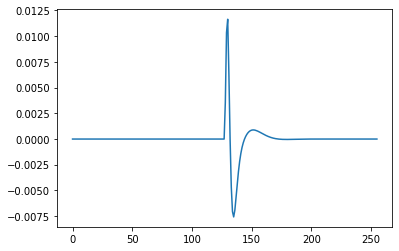

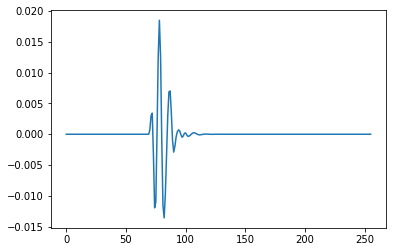

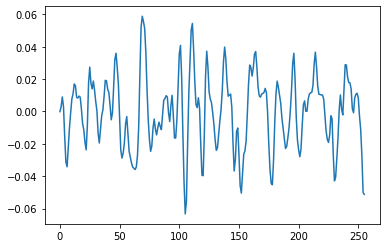

In [4]:
bf=Butterworth(False,True,True,2,0.5,2,2.0,0.05)
d=TimeSeries(d1)
bf.apply(d)
plt.plot(t,d.data)
plt.show()
d=TimeSeries(d2)
bf.apply(d)
plt.plot(t,d.data)
plt.show()
d=TimeSeries(d3)
bf.apply(d)
plt.plot(t,d.data)
plt.show()

This test validates our code as the three plots above are identical in shape to the ones computed from obspy (numpy).  They do, however, demonstrate a difference in scale: the amplitudes of the obspy filtered data are significantly larger than the mspass (SU) filters.  Those familiar with signal processing should not be surprised by that difference, as it simply represents a difference in normalization of the filter coefficients by the two implementations.   To preserve absolute amplitude by either method requires computing the actual transfer function of the filter and using it for a response correction.  We do not address this issue here but emphasize that in most applications preserving relative amplitude absolute amplitudes (e.g. data can be compared to synthetics provided the synthetics are filtered by the same function applied to the data) 

There are several more important points to make about differences between the two implementations:
- The obspy filter uses the traditional subroutine (void function in C) model for encapsulating an algorithm.  The function gets the parameters that describe the algorithm in the argument list.  Our MsPASS implementation follows a different model common object oriented design of "creation is initialization".  That is, the properties of the operator, which in this case is a Butterworth filter, are defined once when the object (Butterworth) is constructed.  
- The subroutine model is most appropriate when the parameters being used to handle the data change frequently since they can change on every call and there is no difference in cost. 
- The OOP approach (the apply method used above) is more efficient in a parallel environment where the same operator is applied many many times to a (presumed large) set of data objects.  
- The efficiency gained in the OOP method for this particular algorithm in a parallel setting is minor because the degree of initialization required for this particular algorithm is very small.  There are many other common examples, however, where that difference is not small at all.  An example in MsPASS is our deconvolution code.  All the methods there have substantial setup costs that are reduced by using the OOP model for processing. 
- A more subtle difference in these two algorithms is complete "under the hood".   In the benchmark tests below we should not be surprised if the MsPASS filter method outpreforms the obspy one.  The key difference is not the subroutine versus OOP model but the fact that to adapt the obspy function we had to do a type conversion from an obspy Trace object to TimeSeries and back again.  This requires multiple deep copies under the hood that will degrade performance. 

We now verify that hypothesis with a benchmark using the os time function. 

In [14]:
# We make these copy only as containers to use as workspaces - 
do=TimeSeries(d1)
dm=TimeSeries(d1)
tobspy=0.0
tmspass=0.0
number_to_process=100000
for n in range(number_to_process):
    x=np.random.randn(npts)
    for i in range(npts):
        dm.data[i]=x[i]
        do.data[i]=x[i]
    t0=time.time()
    mspass_signals.filter(do,"bandpass", freqmin=0.5, freqmax=2.0,corners=2)
    t1=time.time()
    tobspy += t1-t0
    t0=time.time()
    bf.apply(dm)
    t1=time.time()
    tmspass += t1-t0
print('Processing time for obspy filter=',tobspy)
print('Processing time for mspass filter=',tmspass)

Processing time for obspy filter= 112.68708205223083
Processing time for mspass filter= 0.4334728717803955


That test resoundingly confirmed the hypothesis that the MsPASS implementation would be faster than the obpsy one.  Let's next test a hypothesis that the primary issue is the conversion to and from TimeSeries from Trace.  Below we repeat the above test but design the bandpass once and store the parameter in the numpy sos container.   Thus, below is a comparison of performance of numpy compared to our implementation:

In [12]:
# this is the numpy filter design function - we call it just once 
# that is totally analagous to calling the Butterworth constructor
sos=signal.butter(2,[0.5,2.0],btype='bandpass',output='sos',fs=20)
tnumpy=0.0
tmspass=0.0
number_to_process=100000
for n in range(number_to_process):
    x=np.random.randn(npts)
    for i in range(npts):
        dm.data[i]=x[i]
    t0=time.time()
    # note this requires a workspace to contain the output - f
    f=signal.sosfilt(sos,x)
    t1=time.time()
    tnumpy += t1-t0
    t0=time.time()
    bf.apply(dm)
    t1=time.time()
    tmspass += t1-t0
print('Processing time for numpy filter=',tnumpy)
print('Processing time for mspass filter=',tmspass)

Processing time for numpy filter= 4.013174533843994
Processing time for mspass filter= 0.33939361572265625


## Features of Butterworth processing object
Given the utility of the Butterworth filter implementation from Seismci Unix adapted for MsPASS, it is worthwhile describing some of the other features the implementation provides that are automatically available through the object oriented design API. 
### Getters and putters

First, there are basic getters.  Let's see their use applied to the bf (Butterworth filter object) defined above:

In [6]:
# First just call all the getters together then print them to explain the content
fclow=bf.low_corner()
fchigh=bf.high_corner()
nlow=bf.npoles_low()
nhigh=bf.npoles_high()
dt=bf.dt()
print('The low frequency corner (highpass element of bandpass)=',fclow)
print('The high frequency corner (lowpass element of bandpass)=',fchigh)
print('Number of poles in low side (highpass element) filter=',nlow)
print('Number of poles on high side (lowpass element) filter=',nhigh)
print('Expected data sample interval=',dt)

The low frequency corner (highpass element of bandpass)= 0.5
The high frequency corner (lowpass element of bandpass)= 2.0
Number of poles in low side (highpass element) filter= 2
Number of poles on high side (lowpass element) filter= 2
Expected data sample interval= 0.05


It is important to recognize that the coefficients to compute the filter are dependent on the sample interval.  I took a dogmatic attitude that the filter properties should be invariant once constructed, BUT the operator should be capable of handling data from multiple sample rates.  Hence, the only putter is this one:

In [7]:
bf.change_dt(0.01)
fclow=bf.low_corner()
fchigh=bf.high_corner()
nlow=bf.npoles_low()
nhigh=bf.npoles_high()
dt=bf.dt()
print('The low frequency corner (highpass element of bandpass)=',fclow)
print('The high frequency corner (lowpass element of bandpass)=',fchigh)
print('Number of poles in low side (highpass element) filter=',nlow)
print('Number of poles on high side (lowpass element) filter=',nhigh)
print('Expected data sample interval=',dt)

The low frequency corner (highpass element of bandpass)= 0.5
The high frequency corner (lowpass element of bandpass)= 2.0
Number of poles in low side (highpass element) filter= 2
Number of poles on high side (lowpass element) filter= 2
Expected data sample interval= 0.01


### Response functions
Butterworth filter has methods to return the two equivalent ways of representing the response of a linear system:  the inpulse response and the response in the frequency domain that is commonly called a transfer function.  The methods have those names.  Here is demonstration of their use:

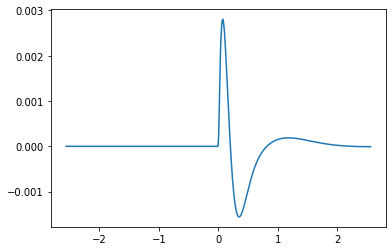

In [8]:
nresp=512
iresp=bf.impulse_response(nresp)
# This is a side illustration of how to directly construct a plot time scale from a TimeSeries object
t=np.linspace(iresp.t0,iresp.time(nresp),nresp)
plt.plot(t,iresp.data)
plt.show()
# transfer function is defined but this fails because there is no wrapper for ComplexArray. Needs attention
#Z=bf.transfer_function(nresp)

### Automated handling of mixed sample rate data
Perhaps the most useful feature of the Butterworth processing object is its ability to automatically handle mixed sample rate data.  To demonstrate that feature the following creates a pair of centered delta functions at two different sample rates.  We filter the two signals with the same operator and show the yield the same result but with a different sample rate.  We'll also create a new zero phase filter with a different passband to demonstrate the variations possible.

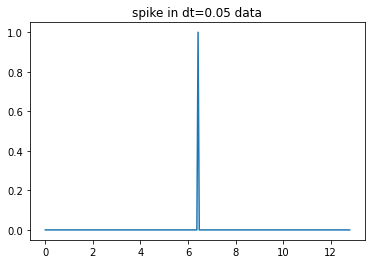

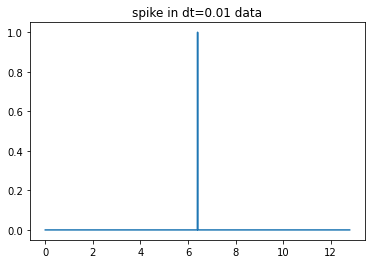

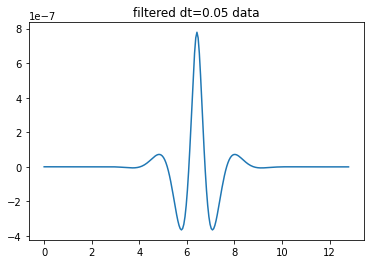

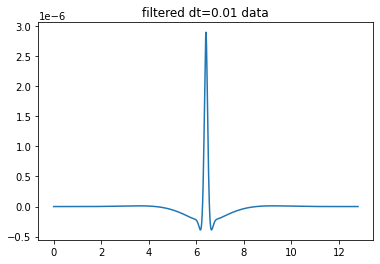

bfz current dt= 0.01  which is sample rate of d4= 0.05


In [9]:
# This initializes he filter with a sample rate of 0.01
bfz=Butterworth(True,True,True,2,0.25,2,3.0,0.01)
# Start with a clone of d2 which has as centered spike and a sample rate of 0.05
d4=TimeSeries(d1)
n4=d4.npts
# set t0 to zero for clarity
d4.t0=0.0
# make d5 a copy of d4 also but then we'll much with the length and sample interval
d5=TimeSeries(d4)
d5.dt=0.01
d5.npts=5*d1.npts   # This will make d5 the same time span as d2=d4
n5=d5.npts
# A feature of the above is it initializes the buffer in d5 to all zeros.  To get a spike
# we only have to insert it where we want
is5=int(n5/2)
d5.data[is5]=1.0
t04=np.linspace(d4.t0,d4.time(n4),n4)
t05=np.linspace(d5.t0,d5.time(n5),n5)
plt.plot(t04,d4.data)
plt.title('spike in dt=0.05 data')
plt.show()
plt.plot(t05,d5.data)
plt.title('spike in dt=0.01 data')
plt.show()
bfz.apply(d5)
bfz.apply(d4)
plt.plot(t04,d4.data)
plt.title('filtered dt=0.05 data')
plt.show()
plt.plot(t05,d5.data)
plt.title('filtered dt=0.01 data')
plt.show()
print('bfz current dt=',bfz.dt(),' which is sample rate of d4=',d4.dt)

There are safety checks to prevent irrational changes in sample rate.  e.g. if one applied the filter above to 0.1 s sample rate data (standard SEED LP channels) it would produce garbage output (typically ringing at the Nyquist frequency but definitely not what you want).  To prevent reduce that problem Butterworth has safeties to override the low or hgih side filtering for absurd sample intervals.  The specific tests are:
1.  If the upper corner (low pass filter) is higher than the 60% of Nyquist the upper corner is disabled.  
2.  If the lower corner is less 1/4 of the signal duration it is disabled.  
If either condition is encountered a complaint error is posted to elog for either a Seismogram or TimeSeries object and the data received will be silently filtered without the offending corner and the dt will be returned to the value prior to being given offending data.  Note there is a modest overhead in that process so handing large amounts of data with sample rates inconsistent with the filter definition will slow processing.  

Below is a demonstration of this behavior:

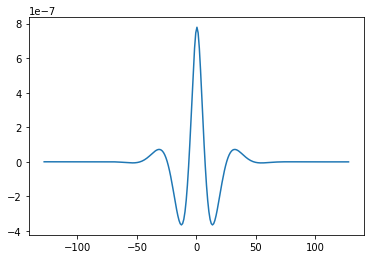

In [12]:
d=TimeSeries(d1)
# force a change in dt to create a conflict
d.dt=1.0
bfz.apply(d)
npts=d.npts
t=np.linspace(d.t0,d.time(npts),npts)
plt.plot(t,d.data)
plt.show()

That ran successfully, but it did so by automatically overriding the low pass filter with a corner at 3 Hz that would have rendered a garbage result.  The error is not fatal but is logged to the objects error log.   We can retrieve that log as follows:

In [13]:
errs=d.elog.get_error_log()
for x in errs:
    print(x)

{'job_id': 0, 'p_id': 1629497, 'algorithm': 'Butterworth::apply', 'message': 'Auto adjust for sample rate change error\nUpper corner of filter=3 is near or above Nyquist frequency for requested sample interval=0.01\nDisabling upper corner (lowpass) and applying filter anyway\n', 'badness': ErrorSeverity.Complaint}


The information is not printed pretty, but shows the message and that it is a complaint.  Normally in processing these data would be automatically dumped to MongoDB.  